In [1]:
import tensorflow as tf
import foolbox as fb

import eagerpy as ep
import numpy as np
import matplotlib.pyplot as plt
import pickle
from urllib.request import urlopen

import glob
from PIL import Image
import os
from os import path

In [2]:
# load key value pairs for class detection
imagenet_key_value_pairs = pickle.load(urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl'))

In [3]:
# preprocess image for foolbox
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    if image.shape[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    image = image[None, ...]
    return image

In [4]:
# decode predictions number to label
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

In [5]:
# find label idx of prediction
def find_label_id(label):
    for key, value in imagenet_key_value_pairs.items():
        if label in value:
            return key

In [6]:
# Keras Applications are canned architectures with pre-trained weights.
pretrained_model = tf.keras.applications.MobileNetV2(weights='imagenet')
preprocessing = dict()
bounds = (-1, 1)

# tensorflow model into foolbox model
fmodel = fb.TensorFlowModel(pretrained_model, bounds=bounds, preprocessing=preprocessing)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Model accuracy on sample images: 1.0


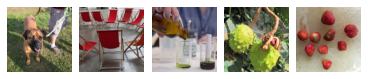

In [7]:
# optionally transform the bounds of the input space of our model
fmodel = fmodel.transform_bounds((0, 1))

# sample images
images, labels = fb.utils.samples(fmodel, dataset='imagenet', batchsize=5)

# check accuracy on sample images and plot them
accuracy = fb.utils.accuracy(fmodel, images, labels)
print('Model accuracy on sample images:', accuracy)
# print(labels)
fb.plot.images(images)
plt.show()
plt.close()

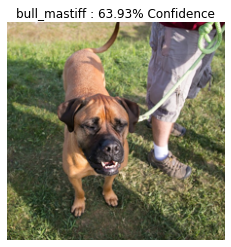

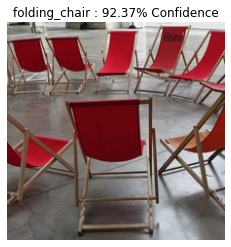

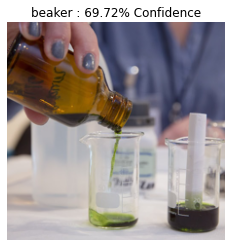

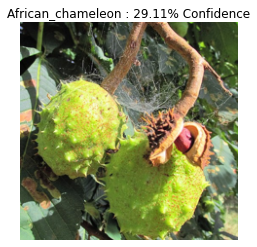

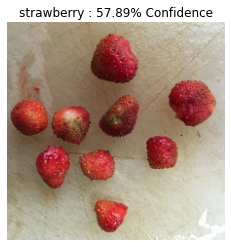

In [9]:
# Predict with pre-trained model
for x in images:
    image = np.expand_dims(x, axis=0)
    image_probs = pretrained_model.predict(image)
    plt.figure()
    plt.imshow(x)  # To change [-1, 1] to [0,1]?
    _, image_class, class_confidence = get_imagenet_label(image_probs)
    plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
    plt.axis('off')
    #plt.close()

In [11]:
# divide files into successive n-sized chunks.
def divide_chunks(l, n):
    # looping till length l
    for i in range(0, len(l), n): 
        yield l[i:i + n]

# load images into a list
list_images = glob.glob('data/*.jpg')
# size of batches that are created from list of images
n = 1
batches = list(divide_chunks(list_images, n))

# for each batch do following steps
# 1: Process image and get original image name and predict class for image.
# 2: Convert the image pixel values and labels for foolbox approved type
# 3: Create attack
# 4: Save crafted images into folder
for batch in batches:
    own_images = [] #preprocessed images
    image_probabilities = []
    image_ids = []
    original_name = []


    for fname in batch:
        image_name = fname.split('data\\')[1]
        original_name.append(image_name.split('.jpg')[0])
        image_raw = tf.io.read_file(fname)
        image = tf.image.decode_image(image_raw)
        image = preprocess(image)
        own_images.append(image)
        image_probs = pretrained_model.predict(image)
        image_probabilities.append(image_probs)    
    if path.exists('adv_data_pgd/{}'.format(image_name)):
        print('Adversarial file exists')
        continue
    for x, y, name in zip(own_images, image_probabilities, original_name):
        #plt.figure()
        #plt.imshow(x[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]?
        _, image_class, class_confidence = get_imagenet_label(y)
        image_class = image_class.replace("_", " ")
        print(name, str(find_label_id(image_class)) + ' = ' + image_class) # if none error incurs later
        image_ids.append(find_label_id(image_class))
        #plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
        #plt.close()



    # Prints values of pixels
    print('Min values in image-array: ' + str(np.amin(own_images)) + ' Max values in image-array: ' + str(np.amax(own_images)))
    #Convert own images and corresponding labels for foolbox approved type
    own_images_tf = []
    own_labels_tf = tf.convert_to_tensor(image_ids, dtype=tf.int32)
    for x in own_images.copy():
        a = tf.squeeze(x)
        a = (a + 1.0)/2 # shift from [-1,1] to [0,1] with 0.5 mean
        own_images_tf.append(a)
    own_images_tf = tf.convert_to_tensor(own_images_tf, dtype=tf.float32)
    # Prints values of pixels after processing
    print('Min values in image-array: ' + str(np.amin(own_images_tf)) + ' Max values in image-array: ' + str(np.amax(own_images_tf)))
    # Testing that conversion works
    #fb.plot.images(own_images_tf)
    accuracy = fb.utils.accuracy(fmodel, own_images_tf, own_labels_tf)
    print('Model accuracy on own images:', accuracy)



    # instantiate the corresponding attack class
    def attack_type(attack):
        if attack == 'LinfPGD':
            return fb.attacks.LinfProjectedGradientDescentAttack()
        elif attack == 'FGSM':
            return fb.attacks.LinfFastGradientAttack()
        elif attack == 'CW_L2':
            return fb.attacks.L2CarliniWagnerAttack()
        elif attack == 'DeepFool':
            return fb.attacks.L2DeepFoolAttack()
        else:
            print('Select valid attack')

    #steps = 10
    #epsilons = np.linspace(0.0, 0.10, num=steps)
    epsilons = [0.05]
    attacks = ['LinfPGD',
              'FGSM',
              'CW_L2',
              'DeepFool']
    attack = attack_type(attacks[0])
    print(attack)
    # use eagerpy tensors own images
    images = ep.astensor(own_images_tf)
    labels = ep.astensor(own_labels_tf)
    # all are tensors
    # raw = The raw adversarial examples. --> depends on attack
    # clipped = The clipped adversarial examples --> guaranteed to not be perturbed more than epsilon.
    # is_adv = boolean for each sample image. True if misclassified and within the epsilon balls around the clean sample.
    raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=epsilons)
    print(is_adv.float32().mean(axis=-1))
    robust_accuracy = 1 - is_adv.float32().mean(axis=-1)
    # show accuracy vs epsilons
    plt.plot(epsilons, robust_accuracy.numpy(), color='blue', linestyle='solid', marker='o', markerfacecolor='red')
    plt.show()
    plt.close()



    # Creates figure object containing image, class and class confidence
    class MyFigure:
        def __init__(self, image , image_class, class_confidence):
            self.image = image
            self.image_class = image_class
            self.class_confidence = class_confidence

    # Save images
    def save_images(images):
        for x in range(0, len(images)):
            _, image_class, class_confidence = get_imagenet_label(image_probs)
            name = original_name[x]
            try:
                plt.imsave('adv_data/{}.jpg'.format(original_name[x]), images[x].image)
            except:
                print('ERROR while saving')


    for perturbed_step, epsilon in zip(clipped, epsilons):
        list_of_figures = []

        for x in perturbed_step:
            x = x.numpy()
            image = np.expand_dims(x, axis=0)
            image_probs = pretrained_model.predict(image)
            _, image_class, class_confidence = get_imagenet_label(image_probs)       

            #create fig object
            a = MyFigure(x, image_class, class_confidence)
            list_of_figures.append(a)

        save_images(list_of_figures)

Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file

Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file

Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file

Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file

Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file

Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file

Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file

Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file

Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file

Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file

Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file

Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file

Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file

Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file

Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file exists
Adversarial file

In [12]:
# show adversary
for adversary, epsilon in zip(clipped, epsilons):
    print('Epsilon value of adversary:', str(epsilon))
    fb.plot.images(adversary - images, bounds=(-0.1, 0.1), scale=4.)
    plt.show()
    plt.close()

NameError: name 'clipped' is not defined

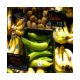

In [29]:
# show adversarial images using fb.plot
for adversary in clipped:
    fb.plot.images(adversary)
    plt.show()
    plt.close()

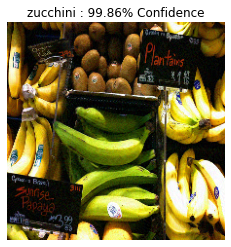

In [30]:
# helper variables for visualizing only one image
row_number = 0 # 0-len(epsilon)

raw_adversarial_images = raw[row_number].numpy()
clipped_adversarial_images = clipped[row_number].numpy()

# Predict adversarial image and show visualization
for x in clipped_adversarial_images:
    image = np.expand_dims(x, axis=0)
    image_probs = pretrained_model.predict(image)
    plt.figure()
    plt.imshow(x)  # To change [-1, 1] to [0,1] #  * 0.5 + 0.2
    _, image_class, class_confidence = get_imagenet_label(image_probs)
    plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
    plt.axis('off')
    plt.show()